
5. Split Data

In [68]:
import tensorflow as tf
from collections import Counter
from pathlib import Path

# Importing modules 
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2

from keras.utils import to_categorical
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.models import Sequential

from sklearn.model_selection import train_test_split

np.random.seed(1)

IMG_SIZE   = (256, 256)
BATCH_SIZE = 32
SEED       = 123

ROOT_DIR   = "potato-diseases-datasets"     # original images
TEST_DIR   = "potato-diseases-test"         # balanced hold-out set

In [56]:
train_raw = tf.keras.utils.image_dataset_from_directory(
    ROOT_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

val_raw = tf.keras.utils.image_dataset_from_directory(
    ROOT_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

test_raw = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

Found 451 files belonging to 7 classes.
Using 361 files for training.
Found 451 files belonging to 7 classes.
Using 90 files for validation.
Found 56 files belonging to 7 classes.


In [57]:
train_raw

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


4. Scale Data

In [58]:
def normalise(ds):
    return ds.map(lambda x, y: (x / 255.0, y), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = normalise(train_raw).prefetch(tf.data.AUTOTUNE)
val_ds   = normalise(val_raw).prefetch(tf.data.AUTOTUNE)
test_ds  = normalise(test_raw).prefetch(tf.data.AUTOTUNE)

class_names = train_raw.class_names 

In [59]:
def count_labels(ds):
    counter = Counter()
    for _, labels in ds.unbatch():
        counter[int(labels.numpy())] += 1
    return [counter[i] for i in range(len(class_names))]

train_counts = count_labels(train_ds)
val_counts   = count_labels(val_ds)
test_counts  = count_labels(test_ds)

In [60]:
train_counts

[46, 47, 52, 49, 67, 55, 45]

In [61]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

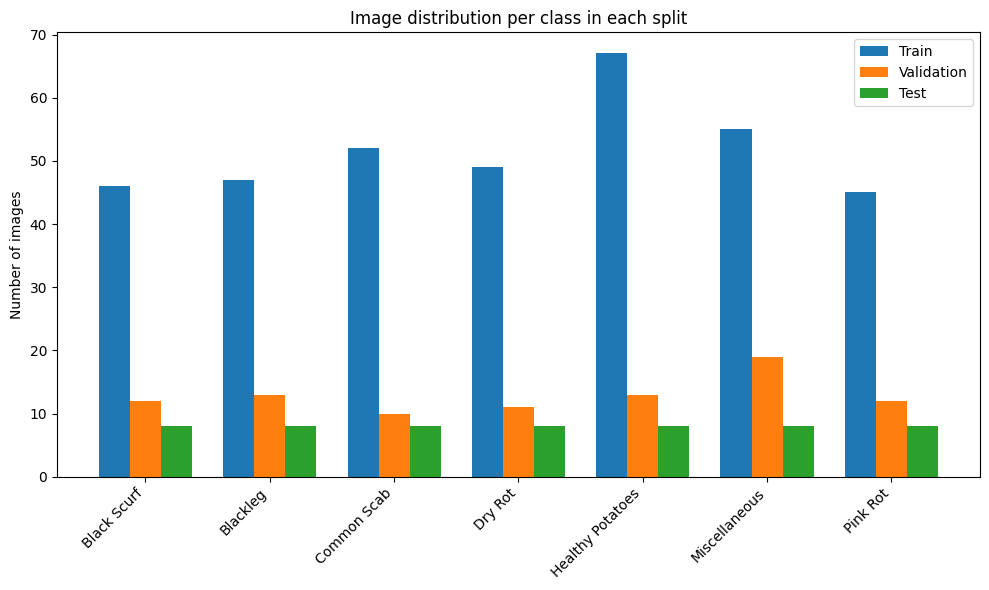

In [62]:
x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, train_counts, width, label="Train")
ax.bar(x, val_counts, width, label="Validation")
ax.bar(x + width, test_counts, width, label="Test")

ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_ylabel("Number of images")
ax.set_title("Image distribution per class in each split")
ax.legend()

plt.tight_layout()
plt.show()


Deep Learning Model

In [63]:
# ───────────────────────────────────────────────────────────────
# BLOCK A  Imports and global configuration
# ───────────────────────────────────────────────────────────────
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

In [64]:
# ───────────────────────────────────────────────────────────────
# BLOCK B  Data-augmentation and normalisation pipeline
#          - applies ONLY to the training stream
# ───────────────────────────────────────────────────────────────
IMG_SIZE   = (256, 256)
BATCH_SIZE = 16          # match the original example
NUM_CLASSES = len(train_raw.class_names)

# augment = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.15),
#     tf.keras.layers.RandomZoom(0.15),
#     tf.keras.layers.RandomContrast(0.15)
# ], name="augment")

train_raw

# def add_preprocessing(ds, training):
#     # ONE rescale only
#     ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
#                 num_parallel_calls=tf.data.AUTOTUNE)
#     if training:
#         ds = ds.map(lambda x, y: (augment(x, training=True), y),
#                     num_parallel_calls=tf.data.AUTOTUNE)
#         ds = ds.shuffle(1000)
#     return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# train_ds = add_preprocessing(train_raw, training=True)
# val_ds   = add_preprocessing(val_raw,   training=False)
# test_ds  = add_preprocessing(test_raw,  training=False)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [48]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [49]:
tiny = train_ds.take(1).repeat()      # ~16 images because batch_size=16

test_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, 3, activation='relu', input_shape=(256,256,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation='softmax')
])
test_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

test_model.fit(tiny, steps_per_epoch=20, epochs=20)

Epoch 1/20
20/20 [==============================] - 6s 294ms/step - loss: 55.1485
Epoch 2/20
20/20 [==============================] - 6s 299ms/step - loss: 8.5031
Epoch 3/20
20/20 [==============================] - 6s 295ms/step - loss: 1.8131
Epoch 4/20
20/20 [==============================] - 6s 305ms/step - loss: 0.7194
Epoch 5/20
20/20 [==============================] - 6s 287ms/step - loss: 0.4014
Epoch 6/20
20/20 [==============================] - 6s 308ms/step - loss: 0.1871
Epoch 7/20
20/20 [==============================] - 7s 361ms/step - loss: 0.1200
Epoch 8/20
20/20 [==============================] - 7s 335ms/step - loss: 0.0659
Epoch 9/20
20/20 [==============================] - 6s 305ms/step - loss: 0.0490
Epoch 10/20
20/20 [==============================] - 6s 320ms/step - loss: 0.0226
Epoch 11/20
20/20 [==============================] - 6s 296ms/step - loss: 0.0167
Epoch 12/20
20/20 [==============================] - 6s 296ms/step - loss: 0.0140
Epoch 13/20
20/20 [=====

In [65]:
# take a batch from the real training stream fed to the model
for imgs, lbls in train_ds.take(1):
    print(tf.reduce_min(imgs).numpy(), tf.reduce_max(imgs).numpy())
    (imgs, _), = train_ds.take(1)           # one batch
print("min/max:", imgs.numpy().min(), imgs.numpy().max())
print("mean pixel:", imgs.numpy().mean())

0.0 1.0
min/max: 0.0 1.0
mean pixel: 0.52596325


In [66]:
base = tf.keras.applications.EfficientNetB0(include_top=False,
                                            weights='imagenet',
                                            input_shape=(224,224,3))
base.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Resizing(224,224),
    tf.keras.layers.Rescaling(1./255),          # single scaling
    augment,
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=15,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                               patience=4, restore_best_weights=True)])

Epoch 1/15
12/12 [==============================] - 20s 643ms/step - loss: 1.9795 - accuracy: 0.1468 - val_loss: 1.9614 - val_accuracy: 0.1444
Epoch 2/15
12/12 [==============================] - 6s 507ms/step - loss: 1.9757 - accuracy: 0.1773 - val_loss: 1.9553 - val_accuracy: 0.1444
Epoch 3/15
12/12 [==============================] - 6s 501ms/step - loss: 1.9622 - accuracy: 0.1634 - val_loss: 1.9428 - val_accuracy: 0.2111
Epoch 4/15
12/12 [==============================] - 6s 503ms/step - loss: 1.9632 - accuracy: 0.1884 - val_loss: 1.9772 - val_accuracy: 0.1444
Epoch 5/15
12/12 [==============================] - 6s 502ms/step - loss: 1.9636 - accuracy: 0.1773 - val_loss: 1.9386 - val_accuracy: 0.1444
Epoch 6/15
12/12 [==============================] - 7s 528ms/step - loss: 1.9760 - accuracy: 0.1440 - val_loss: 1.9427 - val_accuracy: 0.1444
Epoch 7/15
12/12 [==============================] - 7s 528ms/step - loss: 1.9791 - accuracy: 0.1330 - val_loss: 1.9721 - val_accuracy: 0.1444
Epoch

In [29]:
# ───────────────────────────────────────────────────────────────
# BLOCK C  Model architecture (deep CNN similar to the example,
#           but final layer set to 7 classes)
# ───────────────────────────────────────────────────────────────
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(*IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 58, 58, 64)       

In [30]:
# ───────────────────────────────────────────────────────────────
# BLOCK D  Compile, callbacks, and training
# ───────────────────────────────────────────────────────────────
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',   # labels are ints
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_cnn_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 1.9496 - accuracy: 0.1551
Epoch 1: val_accuracy improved from -inf to 0.14444, saving model to best_cnn_weights.h5
12/12 [==============================] - 16s 153ms/step - loss: 1.9496 - accuracy: 0.1551 - val_loss: 1.9476 - val_accuracy: 0.1444
Epoch 2/30
11/12 [==========================>...] - ETA: 0s - loss: 1.9686 - accuracy: 0.1875
Epoch 2: val_accuracy improved from 0.14444 to 0.21111, saving model to best_cnn_weights.h5
12/12 [==============================] - 1s 69ms/step - loss: 1.9680 - accuracy: 0.1856 - val_loss: 1.9441 - val_accuracy: 0.2111
Epoch 3/30
11/12 [==========================>...] - ETA: 0s - loss: 1.9446 - accuracy: 0.1534
Epoch 3: val_accuracy did not improve from 0.21111
12/12 [==============================] - 1s 57ms/step - loss: 1.9447 - accuracy: 0.1524 - val_loss: 1.9424 - val_accuracy: 0.2111
Epoch 4/30
11/12 [==========================>...] - ETA: 0s - loss: 1.9435 - accuracy: 0.1534


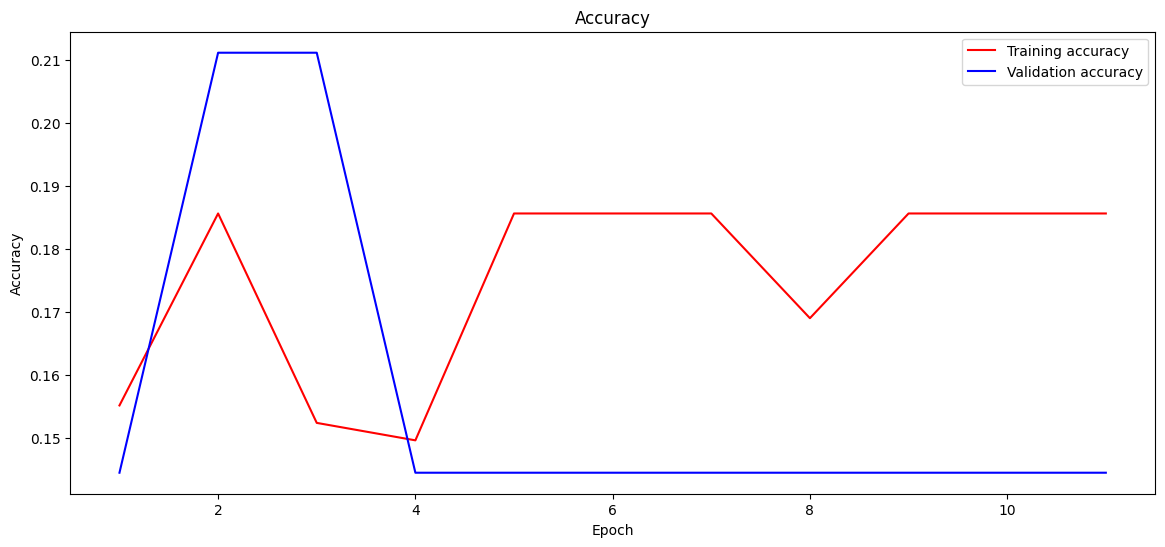

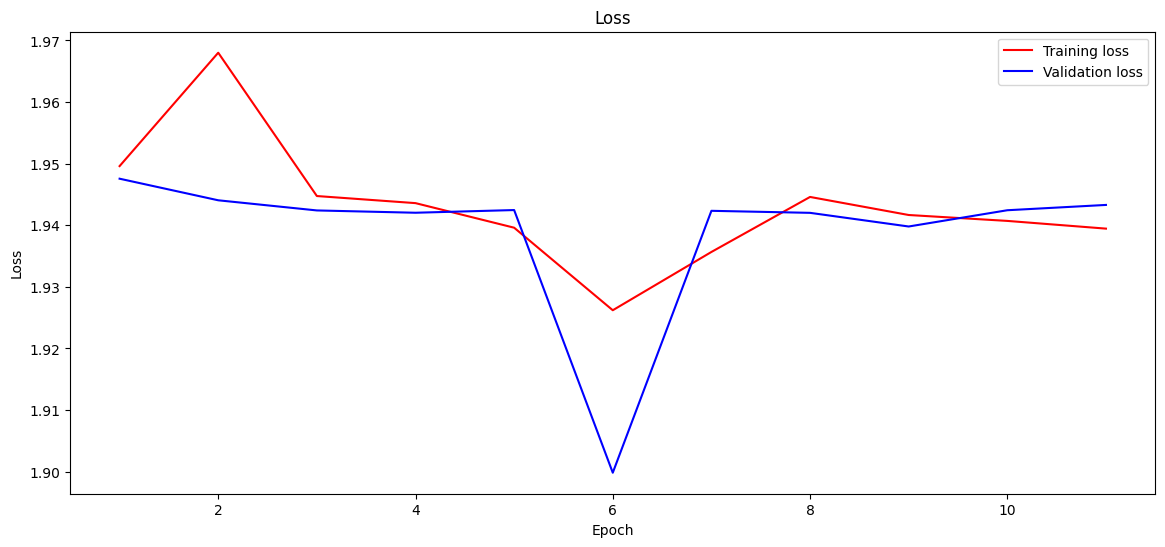

In [31]:
# ───────────────────────────────────────────────────────────────
# BLOCK E  Plot training curves (accuracy and loss)
# ───────────────────────────────────────────────────────────────
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 1s 44ms/step - loss: 1.9511 - accuracy: 0.1429
Test accuracy: 0.143
1/1 [==============================] - 0s 37ms/step


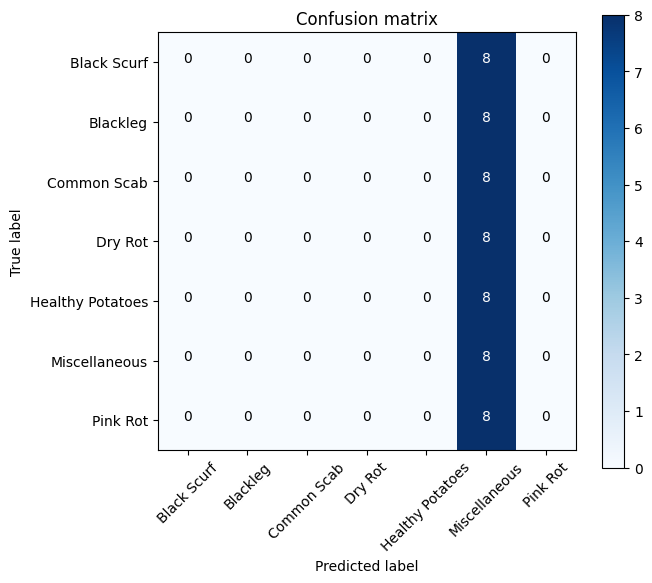

In [51]:
# ───────────────────────────────────────────────────────────────
# BLOCK F  Evaluate on the balanced test set and build a
#          confusion matrix
# ───────────────────────────────────────────────────────────────
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

y_true, y_pred = [], []
for images, labels in test_ds.unbatch():
    preds = model.predict(images[None, ...])
    y_true.append(labels.numpy())
    y_pred.append(np.argmax(preds))

cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title); plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt_color = "white" if cm[i, j] > thresh else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=txt_color)
    plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()

plot_confusion_matrix(cm, classes=train_raw.class_names)
plt.show()

In [33]:
# Unfreeze last two EfficientNet blocks (they start with 'block6' and 'block7')
for layer in base.layers[-80:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # tiny step size
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

NameError: name 'base' is not defined


Train

In [195]:
log_dir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

In [196]:
history = model.fit(
    train,
    validation_data=val,
    epochs=200,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3)
    ]
)

Epoch 1/200


 6/11 [===============>..............] - ETA: 2s - loss: 1.9463 - accuracy: 0.1510

KeyboardInterrupt: 


Plot Performance

In [197]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

2/2 [==============================] - 0s 85ms/step - loss: 1.9550 - accuracy: 0.1429
Test accuracy: 0.143


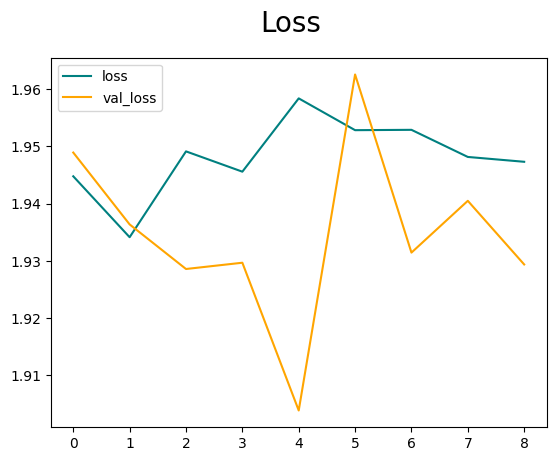

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()